In [1]:
import numpy as np
import pandas as pd
from customized import preprocess
from customized import metrics
from customized import end2end_repeat
from striatum import MAB
from striatum.storage.action import Action
from neural_exploration import neuralucb_main

[Autoencode streamer-product features]
[Test] change Double to Float
Step [1/1], Reconstructed Loss: 0.0179
product feature: (10, 32)
streamer feature: (10, 23)
small streamer-product: (10, 55)


  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Recommend Ratio: 99.00 %
Accuracy: 49.00 %
tp: 49
tn: 0
fp: 50
fn: 1
Precision: 49.49 %
Recall: 98.00 %
Correct: 49
Regret: 50.0 %
Early Stop times: 0


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Recommend Ratio: 100.00 %
Accuracy: 50.00 %
tp: 50
tn: 0
fp: 50
fn: 0
Precision: 50.00 %
Recall: 100.00 %
Correct: 50
Regret: 50.0 %
Early Stop times: 0


  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Recommend Ratio: 100.00 %
Accuracy: 50.00 %
tp: 50
tn: 0
fp: 50
fn: 0
Precision: 50.00 %
Recall: 100.00 %
Correct: 50
Regret: 50.0 %
Early Stop times: 4


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


Recommend Ratio: 100.00 %
Accuracy: 50.00 %
tp: 50
tn: 0
fp: 50
fn: 0
Precision: 50.00 %
Recall: 100.00 %
Correct: 50
Regret: 50.0 %
Early Stop times: 3
aenn's regret: 50.0 %
vaenn's regret: 50.0 %
aebnn's regret: 50.0 %
vaebnn's regret: 50.0 %


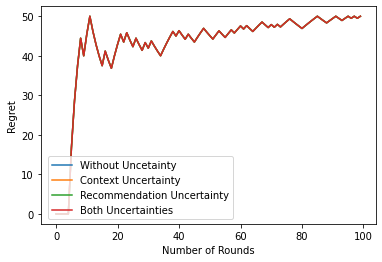

aenn's coverage: 100.0 %
vaenn's coverage: 100.0 %
aebnn's coverage: 86.0 %
vaebnn's coverage: 100.0 %


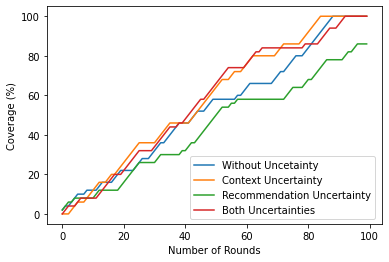

aenn's diversity: 100.0 %
vaenn's diversity: 100.0 %
aebnn's diversity: 100.0 %
vaebnn's diversity: 100.0 %


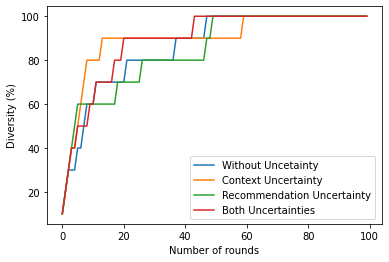

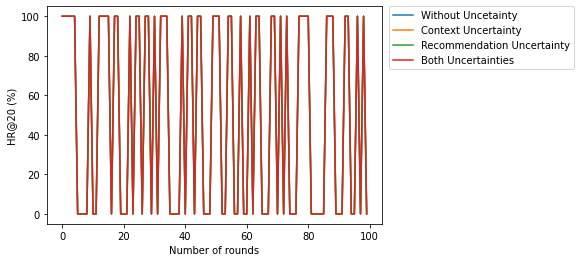

aenn's hit ratio: 20.0 %
vaenn's hit ratio: 20.0 %
aebnn's hit ratio: 20.0 %
vaebnn's hit ratio: 20.0 %


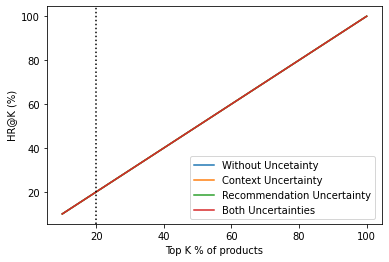

In [2]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'end2end_lers_uncertainty'
regrets_structure, hr_structure, coverage_structure, diversity_structure, \
repeat_reward_pivot, cust_id, reward_cust_id, reward_prod_id, hr_per_round = \
    end2end_repeat.main(experiments, mylabels, fig_name, 100, 10, z_dim=20,weight_eps=1)

# MAB

In [3]:
import importlib
importlib.reload(MAB)

def main(num, full_context, context_id, rewards, streamer_proudct, lers_regret, lers_hr, lers_coverage, lers_diversity): # 2602人, 815dim
    
    actions = []
    for prod_id in streamer_proudct:
        action = Action(int(prod_id))
        actions.append(action)
    user_features = pd.DataFrame(np.array(full_context), index=context_id)
    repeat_rewards_df = pd.melt(rewards, ignore_index=False, var_name='商品id', value_name='reward')\
                    .loc[context_id[:10]].reset_index()
    print(f"user features: {user_features.shape}, reward targets: {rewards.shape}")
    
    experiment_bandit = ['aenn','vaenn','aebnn','vaebnn', 'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'random']
    mab_bandit = ['random', 'UCB1', 'LinUCB', 'Exp3']
    mylabels = ['LERS (Without Uncertainty)','LERS (Context Uncertainty)','LERS (Recommendation Uncertainty)', 'LERS (Both Uncertainties)', \
               'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'Random']
    predict_id = {}
    rec_id = {}
    regret = {}
    hr = {}
    topk = {}
    coverage_dict = {} 
    diversity_dict = {}

    for bandit in experiment_bandit:   
        if bandit in mab_bandit:      
            print("-----")
            print(bandit)
            policy = MAB.policy_generation(bandit, actions)
            seq_error, rec_id[bandit], predict_id[bandit] = MAB.policy_evaluation(policy, bandit, num, user_features, rewards, actions, len(actions))
            regret[bandit] = MAB.regret_calculation(seq_error)
            # hit_ratio
            if bandit != 'random':
                hr[bandit], k_list, topk[bandit] = metrics.cal_hit_ratio_mab(num, repeat_rewards_df, predict_id[bandit], min_val=10, max_val=110, step=10)
            # coverage
            coverage_dict[bandit] = MAB.cal_coverage_repeat(num, bandit, repeat_rewards_df, rewards, rec_id[bandit])
            # diversity
            diversity_dict[bandit] = metrics.cal_diversity(len(streamer_proudct), rec_id[bandit])
            
        elif bandit == 'NeuralUCB':
            neuralUCB_regret, neuralUCB_reward_df, predict_id[bandit] = neuralucb_main.myNeuralUCB(user_features, rewards, p=0.2, hidden_size=32, epochs=10, use_cuda=False, seed=np.random.seed(2022))
            regret['NeuralUCB'] = neuralUCB_regret
            # hit_ratio
            hr[bandit], _, topk[bandit] = metrics.cal_hit_ratio_neuralucb(num, repeat_rewards_df, predict_id[bandit], min_val=10, max_val=110, step=10)
            # coverage
            neuralUCB_cover_miss = neuralucb_main.coverage(neuralUCB_reward_df)
            coverage_dict['NeuralUCB'] = neuralUCB_cover_miss['cover']
            # diversity
            neuralucb_rec_id = [element[0] for element in predict_id[bandit]]
            diversity_dict['NeuralUCB'] = metrics.cal_diversity(len(streamer_proudct), neuralucb_rec_id)
        else:
            regret[bandit] = lers_regret[bandit]
            hr[bandit] = lers_hr[bandit]
            coverage_dict[bandit] = lers_coverage[bandit]
            diversity_dict[bandit] = lers_diversity[bandit]        
        
    # plot regret 
    metrics.plot_regret(regret, mylabels, 'end2end_all_uncertainty', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    # plot hit ratio
    metrics.plot_hit_ratio(hr, k_list, mylabels, 'end2end_all_uncertainty', bbox_to_anchor=(1.02, 1), loc=2)    
    # plot coverage     
    metrics.plot_coverage(coverage_dict, mylabels, 'end2end_all_uncertainty', bbox_to_anchor=(1.02, 1), loc=2)
    # plot diversity     
    metrics.plot_diversity(diversity_dict, mylabels, 'end2end_all_uncertainty', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    
    return regret, hr, coverage_dict, diversity_dict, predict_id

## blurry_context

user features: (100, 20), reward targets: (100, 10)
-----
UCB1
Correct 51
=====hit=====
[Final] cumulative cover ratio is:  66.0000
user
10216769084013373    2
1182060652291740     3
132951068172795      2
147570737452163      4
1595107157361238     3
2246906995347384     4
3240887732596929     4
4976976049064048     4
5821434374564784     4
6185796358112538     3
Name: cnt, dtype: int64
=====miss=====
[Final] cumulative miss ratio is:  64.00 %
user
10216769084013373    5
1182060652291740     3
132951068172795      3
147570737452163      2
1595107157361238     4
2246906995347384     3
3240887732596929     2
4976976049064048     3
5821434374564784     3
6185796358112538     4
Name: cnt, dtype: int64
-----
LinUCB
Correct 77
=====hit=====
[Final] cumulative cover ratio is:  28.0000
user
10216769084013373    1
1182060652291740     2
132951068172795      1
147570737452163      1
1595107157361238     2
2246906995347384     1
3240887732596929     1
4976976049064048     2
5821434374564784     

  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03

=====hit=====
[Final] cumulative cover ratio is:  64.0000
user
10216769084013373    3
1182060652291740     3
132951068172795      2
147570737452163      4
1595107157361238     4
2246906995347384     4
3240887732596929     2
4976976049064048     3
5821434374564784     3
6185796358112538     4
Name: cnt, dtype: int64
=====miss=====
[Final] cumulative miss ratio is:  56.00 %
user
10216769084013373    3
1182060652291740     3
132951068172795      4
1595107157361238     2
2246906995347384     3
3240887732596929     3
4976976049064048     4
5821434374564784     4
6185796358112538     2
Name: cnt, dtype: int64


100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


-----
random
Correct 47
=====hit=====
[Final] cumulative cover ratio is:  60.0000
user
10216769084013373    3
1182060652291740     3
132951068172795      2
147570737452163      2
1595107157361238     3
2246906995347384     2
3240887732596929     4
4976976049064048     3
5821434374564784     4
6185796358112538     4
Name: cnt, dtype: int64
=====miss=====
[Final] cumulative miss ratio is:  64.00 %
user
10216769084013373    5
1182060652291740     4
132951068172795      3
147570737452163      4
1595107157361238     2
2246906995347384     2
3240887732596929     2
4976976049064048     4
5821434374564784     3
6185796358112538     3
Name: cnt, dtype: int64
aenn's regret: 50.0 %
vaenn's regret: 50.0 %
aebnn's regret: 50.0 %
vaebnn's regret: 50.0 %
UCB1's regret: [48.] %
LinUCB's regret: [22.] %
Exp3's regret: [47.] %
NeuralUCB's regret: 49.0 %
random's regret: [52.] %


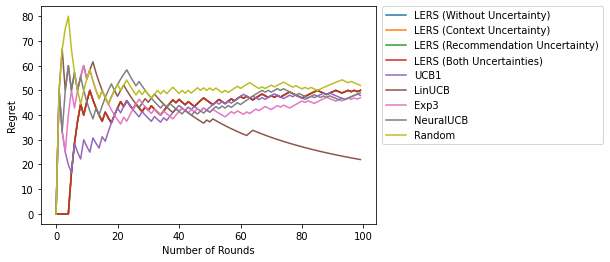

aenn's hit ratio: 20.0 %
vaenn's hit ratio: 20.0 %
aebnn's hit ratio: 20.0 %
vaebnn's hit ratio: 20.0 %
UCB1's hit ratio: 36.0 %
LinUCB's hit ratio: 28.0 %
Exp3's hit ratio: 30.0 %
NeuralUCB's hit ratio: 20.0 %


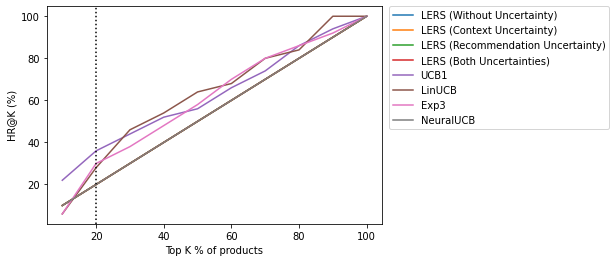

aenn's coverage: 100.0 %
vaenn's coverage: 100.0 %
aebnn's coverage: 86.0 %
vaebnn's coverage: 100.0 %
UCB1's coverage: 66.0 %
LinUCB's coverage: 28.0 %
Exp3's coverage: 64.0 %
NeuralUCB's coverage: 82.0 %
random's coverage: 60.0 %


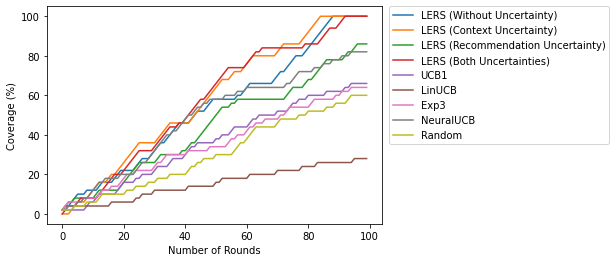

aenn's diversity: 100.0 %
vaenn's diversity: 100.0 %
aebnn's diversity: 100.0 %
vaebnn's diversity: 100.0 %
UCB1's diversity: 100.0 %
LinUCB's diversity: 90.0 %
Exp3's diversity: 100.0 %
NeuralUCB's diversity: 100.0 %
random's diversity: 100.0 %


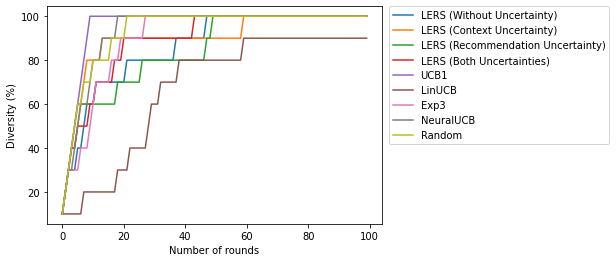

In [4]:
mab_context = np.load('data/mab_context.npy') # mab_context: 20 # mab_latent30
mab_context, mab_context_id, _ = preprocess.trim_cust_for_context_sort(mab_context, cust_id, reward_cust_id)
regret, hr, coverage, diversity, predict_id = main(len(mab_context_id), mab_context, mab_context_id, \
                                  repeat_reward_pivot, reward_prod_id, \
                                  regrets_structure, hr_structure, coverage_structure, diversity_structure) 
